In [3]:
from Bio import SeqIO
import pandas as pd
import numpy as np

from genominterv.remapping import remap
from genominterv.remapping import interval_distance, genomic
from genominterv.remapping import remap_interval_data
import seaborn as sns

## loading eigenvectors using kasper code

In [4]:
def parse_compartment_data(file_name):
    e1_100kb = pd.read_csv(file_name)
    e1_100kb['start'] = [i*100_000 for i in range(e1_100kb.index.size)]
    e1_100kb['end'] = e1_100kb.start + 100_000
    e1_100kb['sign'] = np.sign(e1_100kb.e1)
    e1_100kb['segment_id'] = ((e1_100kb.sign.shift() != e1_100kb.sign)).cumsum()
    
    comp = e1_100kb.groupby('segment_id', as_index=False).agg(dict(
         e1=['mean', 'sum'], 
         start='min', 
         end='max', 
         segment_id='mean', 
         sign='mean'
    ))
    comp.columns = ['_'.join(col).strip() for col in comp.columns.values]
    comp = comp.rename(
        columns={'start_min':'start',
                 'end_max':'end', 
                 'segment_id_mean':'segment_id', 
                 'sign_mean':'sign'}
    )
    comp['comp'] = ['A' if x > 0 else 'B' for x in comp.sign]
    comp = comp.reset_index()
    comp['chrom'] = 'chrX'
    
    _comp = comp.copy()
    for i in range(1, _comp.index.size-1):
        if np.isnan(_comp.loc[i-1, 'e1_mean']):
            _comp.loc[i, 'start'] = np.nan
        if np.isnan(_comp.loc[i+1, 'e1_mean']):
            _comp.loc[i, 'end'] = np.nan
    _comp = _comp.loc[~_comp.e1_mean.isnull(), :]
    _comp = _comp.reset_index()
    compartment_edges = pd.concat([_comp.start, _comp.end]).sort_values().unique()
    
    compartments = comp.loc[~comp.e1_mean.isnull()].copy()
    compartments['start'] = compartments.start.astype(int)
    compartments['end'] = compartments.end.astype(int)

    return compartments, compartment_edges

def edge_segments(compartment_edges, flank):
    compartment_edge_segm = pd.DataFrame(np.column_stack((compartment_edges, compartment_edges+flank)), columns=['start', 'end'])
    compartment_edge_segm['chrom'] = 'chrX'
    return compartment_edge_segm

In [5]:
import os

# Load data
eigentrack_dir = "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/eigentracks"
eigentrack_files = [
    f for f in os.listdir(eigentrack_dir) if f.endswith("_10Mb.csv")
]

comps_dict = {}
edges_dict = {}
generated_comps=[]
generated_edges=[]
a_and_b_comps = []

for filename in eigentrack_files:
    filepath = os.path.join(eigentrack_dir, filename)
    base = os.path.splitext(filename)[0]
    comps_var = f"{base}_comps"
    edges_var = f"{base}_edges"
    comps, edges = parse_compartment_data(filepath)
    comps_dict[comps_var] = comps
    edges_dict[edges_var] = edges
    generated_comps.append(comps_var)
    generated_edges.append(edges_var)

print("Generated variable names:", generated_comps)
print("Generated variable names:", generated_edges)

for edge_var in generated_edges:
    # Get the numpy array of edges from the dictionary
    edges = edges_dict[edge_var]
    
    # Create the DataFrame using edge_segments with flank=1
    seg_name = f"{edge_var}_interval"
    seg_df = edge_segments(edges, 1)
    #print(f"Created: {seg_name}")

    # Merge compartment assignment
    comps_var = edge_var.replace("_edges", "_comps")
    if comps_var in comps_dict:
        comps_df = comps_dict[comps_var]
        
        comp_df = pd.DataFrame({
            'comp': comps_df['comp'].reset_index(drop=True),
            'start': seg_df['start'].reset_index(drop=True),
            'end': seg_df['end'].reset_index(drop=True),
            'chrom': seg_df['chrom'].reset_index(drop=True)
        })

        # Save full merged comp_df
        comp_full_name = f"{edge_var}_interval_comp"
            # Save combined A and B compartments
        comp_AB_name = f"{edge_var}_AB"
        globals()[comp_AB_name] = comp_df
        a_and_b_comps.append(comp_AB_name)

        #print(f"Created: {comp_full_name}")

        # Split into compartments A and B
        comp_A = comp_df[comp_df['comp'] == 'A'].reset_index(drop=True)
        comp_B = comp_df[comp_df['comp'] == 'B'].reset_index(drop=True)

        # Save A and B splits as new variables
        comp_A_name = f"{edge_var}_A"
        comp_B_name = f"{edge_var}_B"
        globals()[comp_A_name] = comp_A
        globals()[comp_B_name] = comp_B
        a_and_b_comps.append(comp_A_name)
        a_and_b_comps.append(comp_B_name)
        
        #print(f"Created: {edge_var}_A and {edge_var}_B")

print("Generated compartment A and B variables:", a_and_b_comps)

#print(sperm_e1_100kb_10Mb_edges_A.head())

print(globals()[comp_AB_name].head())

Generated variable names: ['sperm_e1_100kb_10Mb_comps', 'round_spermatid_e1_100kb_10Mb_comps', 'pachytene_spermatocyte_e1_100kb_10Mb_comps', 'spermatogonia_e1_100kb_10Mb_comps', 'fibroblast_e1_100kb_10Mb_comps']
Generated variable names: ['sperm_e1_100kb_10Mb_edges', 'round_spermatid_e1_100kb_10Mb_edges', 'pachytene_spermatocyte_e1_100kb_10Mb_edges', 'spermatogonia_e1_100kb_10Mb_edges', 'fibroblast_e1_100kb_10Mb_edges']
Generated compartment A and B variables: ['sperm_e1_100kb_10Mb_edges_AB', 'sperm_e1_100kb_10Mb_edges_A', 'sperm_e1_100kb_10Mb_edges_B', 'round_spermatid_e1_100kb_10Mb_edges_AB', 'round_spermatid_e1_100kb_10Mb_edges_A', 'round_spermatid_e1_100kb_10Mb_edges_B', 'pachytene_spermatocyte_e1_100kb_10Mb_edges_AB', 'pachytene_spermatocyte_e1_100kb_10Mb_edges_A', 'pachytene_spermatocyte_e1_100kb_10Mb_edges_B', 'spermatogonia_e1_100kb_10Mb_edges_AB', 'spermatogonia_e1_100kb_10Mb_edges_A', 'spermatogonia_e1_100kb_10Mb_edges_B', 'fibroblast_e1_100kb_10Mb_edges_AB', 'fibroblast_e1_1

## load cpsislands

In [7]:
import pandas as pd
file_path = "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/macaca/cpgIslandExt.txt"
# Load directly from compressed file
df = pd.read_csv(file_path, sep='\t', header=None)

# Assign column names
df.columns = [
    "bin",
    "chrom",
    "chromStart",
    "chromEnd",
    "name",
    "length",
    "cpgNum",
    "gcNum",
    "perCpg",
    "perGc",
    "obsExp"
]

# Show first few rows
print(df.head())

   bin chrom  chromStart  chromEnd      name  length  cpgNum  gcNum  perCpg  \
0  585  chr1       26177     26863   CpG: 77     686      77    446    22.4   
1  585  chr1       56871     57183   CpG: 33     312      33    199    21.2   
2  585  chr1       71413     72476   CpG: 94    1063      94    708    17.7   
3  585  chr1       82173     83468  CpG: 153    1295     153    899    23.6   
4  585  chr1       90820     92065  CpG: 138    1245     138    872    22.2   

   perGc  obsExp  
0   65.0    1.12  
1   63.8    1.04  
2   66.6    0.80  
3   69.4    0.99  
4   70.0    0.91  


UCSC cpgIslandExt Table: Column Descriptions
Column Name	Example	Description
bin	585	UCSC internal field for efficient querying (can usually be ignored).
chrom	chr1	Chromosome name (e.g., chr1, chrX).
chromStart	26177	Start coordinate of the CpG island (0-based, inclusive).
chromEnd	26863	End coordinate of the CpG island (0-based, exclusive).
name	CpG: 77	Island identifier (often encodes CpG count).
length	686	Length of the CpG island (in bp).
cpgNum	77	Number of CpG dinucleotides in the island.
gcNum	446	Number of G or C bases in the island.
perCpg	22.4	Percentage of CpG dinucleotides relative to island length.
perGc	65.0	GC content percentage: (gcNum / length) * 100.
obsExp	1.12	Observed/expected CpG ratio (see formula below).





In [15]:
df_chrX = df[df['chrom'] == 'chrX'].reset_index(drop=True)
print(df_chrX.head())
df_chrX = df_chrX[['chrom', 'chromStart', 'chromEnd']].rename(
    columns={'chromStart': 'start', 'chromEnd': 'end'})
print(df_chrX.head())

   bin chrom  chromStart  chromEnd      name  length  cpgNum  gcNum  perCpg  \
0  585  chrX       44203     44761   CpG: 49     558      49    374    17.6   
1  585  chrX       71313     73056  CpG: 124    1743     124   1177    14.2   
2  585  chrX       75338     76415   CpG: 80    1077      80    693    14.9   
3  585  chrX       77670     78750   CpG: 68    1080      68    667    12.6   
4  585  chrX       80467     85767  CpG: 374    5300     374   3005    14.1   

   perGc  obsExp  
0   67.0    0.81  
1   67.5    0.63  
2   64.3    0.72  
3   61.8    0.66  
4   56.7    0.88  
  chrom  start    end
0  chrX  44203  44761
1  chrX  71313  73056
2  chrX  75338  76415
3  chrX  77670  78750
4  chrX  80467  85767


In [17]:
import numpy as np
import pandas as pd
from genominterv.remapping import remap_interval_data




def plot_repeat_density_vs_compartment_edge(df_repeats, df_compartment_anchors):
    """
    Remaps repeat intervals to a compartment coordinate space and returns the
    A-value and B-value groups based on signed distance logic.

    Parameters:
    - df_repeats: DataFrame of genomic intervals to remap (must have chrom/start/end).
    - df_compartment_anchors: DataFrame with compartment structure (must have chrom/start/end/comp).

    Returns:
    - A_val: DataFrame for Compartment A-assigned intervals
    - B_val: DataFrame for Compartment B-assigned intervals
    """

    # Clean and sort
    sperm_clean = df_compartment_anchors.dropna(subset=["start", "end"]).copy()
    sperm_clean["start"] = sperm_clean["start"].astype(int)
    sperm_clean["end"] = sperm_clean["end"].astype(int)
    df_repeats = df_repeats.dropna(subset=["start", "end"]).copy()
    df_repeats["start"] = df_repeats["start"].astype(int)
    df_repeats["end"] = df_repeats["end"].astype(int)

    # Sort
    sperm_clean = sperm_clean.sort_values(by=['chrom', 'start', 'end'])
    df_repeats = df_repeats.sort_values(by=['chrom', 'start', 'end'])

    # Remap
    result = remap_interval_data(df_repeats, sperm_clean, include_prox_coord=True)

    # Post-process
    result["mid"] = (result["start"] + result["end"]) / 2
    result["absmid"] = result["mid"].abs()
    for col in ["start", "end", "mid", "absmid"]:
        result[col] = result[col].replace([0.0, -0.0], np.nan)
    result = result.dropna(subset=["start", "end", "mid", "absmid", "start_prox", "end_prox"], how="any")

    # Map compartment identity
    start_to_comp = sperm_clean.drop_duplicates(subset=["start"]).set_index("start")["comp"]
    result["comp"] = result["start_prox"].map(start_to_comp)

    # Split into A and B groups based on signed start
    A_val = result[
        ((result['comp'] == 'A') & (result['start'] < 0)) |
        ((result['comp'] == 'B') & (result['start'] > 0))
    ].copy()
    B_val = result[
        ((result['comp'] == 'A') & (result['start'] > 0)) |
        ((result['comp'] == 'B') & (result['start'] < 0))
    ].copy()

    # Add abs start and label
    A_val['abs_start'] = A_val['start'].abs()
    B_val['abs_start'] = B_val['start'].abs()
    A_val['group'] = 'Compartment A'
    B_val['group'] = 'Compartment B'

    return A_val, B_val

A_val, B_val = plot_repeat_density_vs_compartment_edge( df_chrX, sperm_e1_100kb_10Mb_edges_AB)
print(A_val.head())
print(B_val.head())

       start      end  start_prox   end_prox chrom  start_orig  end_orig  \
110 -2826987 -2827606   8300000.0  8300001.0  chrX     5472394   5473013   
111 -2539475 -2539729   8300000.0  8300001.0  chrX     5760271   5760525   
112 -2499897 -2501646   8300000.0  8300001.0  chrX     5798354   5800103   
113 -1610301 -1611364   8300000.0  8300001.0  chrX     6688636   6689699   
114  -836918  -837449   8300000.0  8300001.0  chrX     7462551   7463082   

           mid     absmid comp  abs_start          group  
110 -2827296.5  2827296.5    A    2826987  Compartment A  
111 -2539602.0  2539602.0    A    2539475  Compartment A  
112 -2500771.5  2500771.5    A    2499897  Compartment A  
113 -1610832.5  1610832.5    A    1610301  Compartment A  
114  -837183.5   837183.5    A     836918  Compartment A  
      start     end  start_prox   end_prox chrom  start_orig  end_orig  \
98    20062   20492   2500000.0  2500001.0  chrX     2520063   2520493   
99   412468  413187   2500000.0  2500001.

In [18]:
ab_dfs = {name: obj for name, obj in globals().items()
          if name.endswith('_AB') and isinstance(obj, pd.DataFrame)}
remapped_simple_filter_data = {}

for name, df_anchor in ab_dfs.items():
    print(f"\nRunning on: {name}")
    try:
        A_value, B_value = plot_repeat_density_vs_compartment_edge(df_chrX, df_anchor)
        remapped_simple_filter_data[name.replace('_AB', '')] = {"A": A_value, "B": B_value}
        print(f"  A_value: {A_value.shape}, B_value: {B_value.shape}")
    except Exception as e:
        print(f"  ❌ Failed on {name}: {e}")


Running on: sperm_e1_100kb_10Mb_edges_AB
  A_value: (310, 12), B_value: (384, 12)

Running on: round_spermatid_e1_100kb_10Mb_edges_AB
  A_value: (272, 12), B_value: (485, 12)

Running on: pachytene_spermatocyte_e1_100kb_10Mb_edges_AB
  A_value: (390, 12), B_value: (275, 12)

Running on: spermatogonia_e1_100kb_10Mb_edges_AB
  A_value: (393, 12), B_value: (350, 12)

Running on: fibroblast_e1_100kb_10Mb_edges_AB
  A_value: (439, 12), B_value: (335, 12)


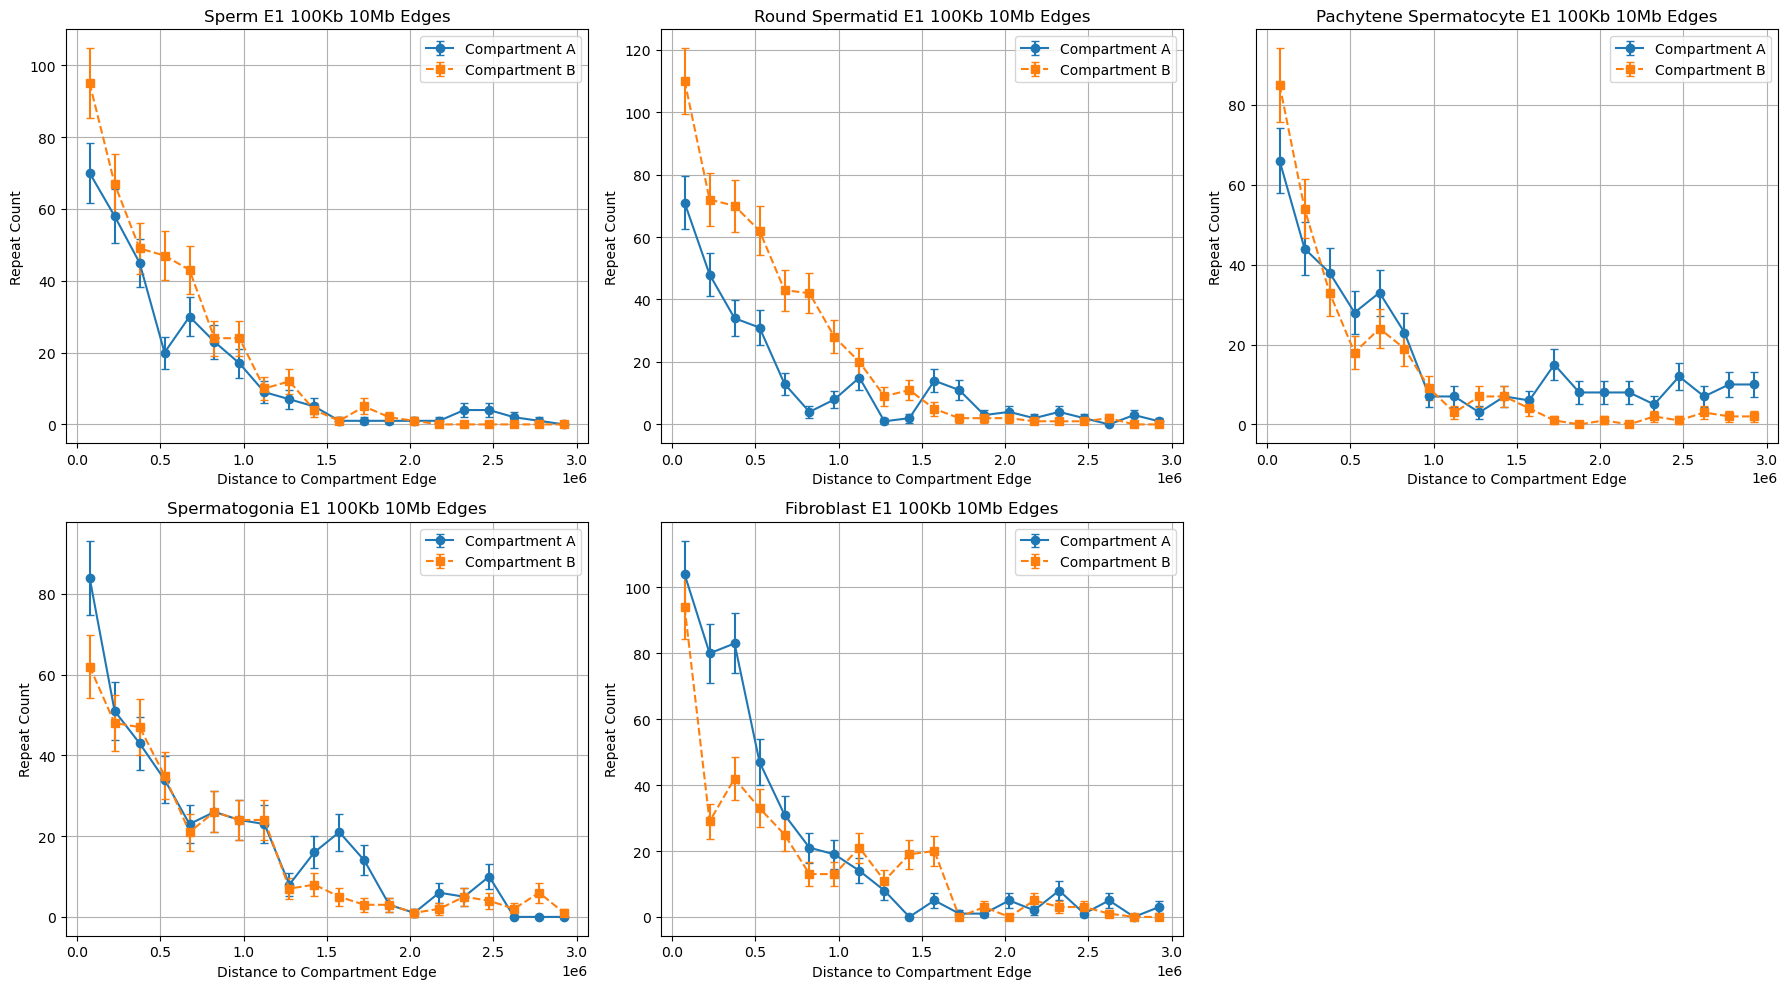

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Plot settings
num_bins = 20
max_dist = 3_000_000
bins = np.linspace(0, max_dist, num_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

def bin_absmid_with_error(absmid_values, bins):
    counts, _ = np.histogram(absmid_values, bins=bins)
    errors = np.sqrt(counts)
    return counts, errors

# Prepare plot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Loop through samples
for idx, (sample, pair) in enumerate(remapped_simple_filter_data.items()):
    A_df = pair["A"]
    B_df = pair["B"]

    # Bin 'absmid'
    counts_A, errors_A = bin_absmid_with_error(A_df['absmid'].dropna(), bins)
    counts_B, errors_B = bin_absmid_with_error(B_df['absmid'].dropna(), bins)

    ax = axes[idx]
    ax.errorbar(bin_centers, counts_A, yerr=errors_A, marker='o', linestyle='-', capsize=3, label='Compartment A')
    ax.errorbar(bin_centers, counts_B, yerr=errors_B, marker='s', linestyle='--', capsize=3, label='Compartment B')
    ax.set_title(sample.replace("_", " ").title())
    ax.set_xlabel("Distance to Compartment Edge")
    ax.set_ylabel("Repeat Count")
    ax.grid(True)
    ax.legend()

# Hide unused subplot (slot 6)
if len(remapped_simple_filter_data) < len(axes):
    for i in range(len(remapped_simple_filter_data), len(axes)):
        axes[i].axis('off')

plt.tight_layout()
plt.show()

# AB or BA

In [20]:
def remapping_no_filter_compartment(df_repeats, df_compartment_anchors):
    """
    Remaps repeats to compartment edges and groups only by target compartment identity,
    ignoring directionality. Returns absolute distances for plotting.

    Parameters:
    - df_repeats: DataFrame with columns chrom, start, end
    - df_compartment_anchors: DataFrame with columns chrom, start, end, comp

    Returns:
    - A_val: DataFrame of repeats near compartment A
    - B_val: DataFrame of repeats near compartment B
    """
    # Clean and sort
    anchors = df_compartment_anchors.dropna(subset=["start", "end"]).copy()
    anchors["start"] = anchors["start"].astype(int)
    anchors["end"] = anchors["end"].astype(int)
    df_repeats = df_repeats.dropna(subset=["start", "end"]).copy()
    df_repeats["start"] = df_repeats["start"].astype(int)
    df_repeats["end"] = df_repeats["end"].astype(int)

    anchors = anchors.sort_values(by=['chrom', 'start', 'end'])
    df_repeats = df_repeats.sort_values(by=['chrom', 'start', 'end'])

    # Remap
    result = remap_interval_data(df_repeats, anchors, include_prox_coord=True)

    # Post-process
    result["mid"] = (result["start"] + result["end"]) / 2
    result["absmid"] = result["mid"].abs()
    result = result.dropna(subset=["start", "end", "mid", "absmid", "start_prox", "end_prox"], how="any")

    # Map compartment identity
    start_to_comp = anchors.drop_duplicates(subset=["start"]).set_index("start")["comp"]
    result["comp"] = result["start_prox"].map(start_to_comp)

    # Split only based on target compartment (ignore direction)
    A_val = result[result['comp'] == 'A'].copy()
    B_val = result[result['comp'] == 'B'].copy()

    A_val["abs_start"] = A_val["start"].abs()
    B_val["abs_start"] = B_val["start"].abs()
    A_val["group"] = "Compartment A"
    B_val["group"] = "Compartment B"

    return A_val, B_val

In [22]:
ab_dfs = {name: obj for name, obj in globals().items()
          if name.endswith('_AB') and isinstance(obj, pd.DataFrame)}
remapped_data = {}

for name, df_anchor in ab_dfs.items():
    print(f"\nRunning on: {name}")
    try:
        A_value, B_value = remapping_no_filter_compartment(df_chrX, df_anchor)
        remapped_data[name.replace('_AB', '')] = {"A": A_value, "B": B_value}
        print(f"  A_value: {A_value.shape}, B_value: {B_value.shape}")
    except Exception as e:
        print(f"  ❌ Failed on {name}: {e}")


Running on: sperm_e1_100kb_10Mb_edges_AB
  A_value: (342, 12), B_value: (352, 12)

Running on: round_spermatid_e1_100kb_10Mb_edges_AB
  A_value: (273, 12), B_value: (484, 12)

Running on: pachytene_spermatocyte_e1_100kb_10Mb_edges_AB
  A_value: (310, 12), B_value: (355, 12)

Running on: spermatogonia_e1_100kb_10Mb_edges_AB
  A_value: (380, 12), B_value: (363, 12)

Running on: fibroblast_e1_100kb_10Mb_edges_AB
  A_value: (305, 12), B_value: (469, 12)


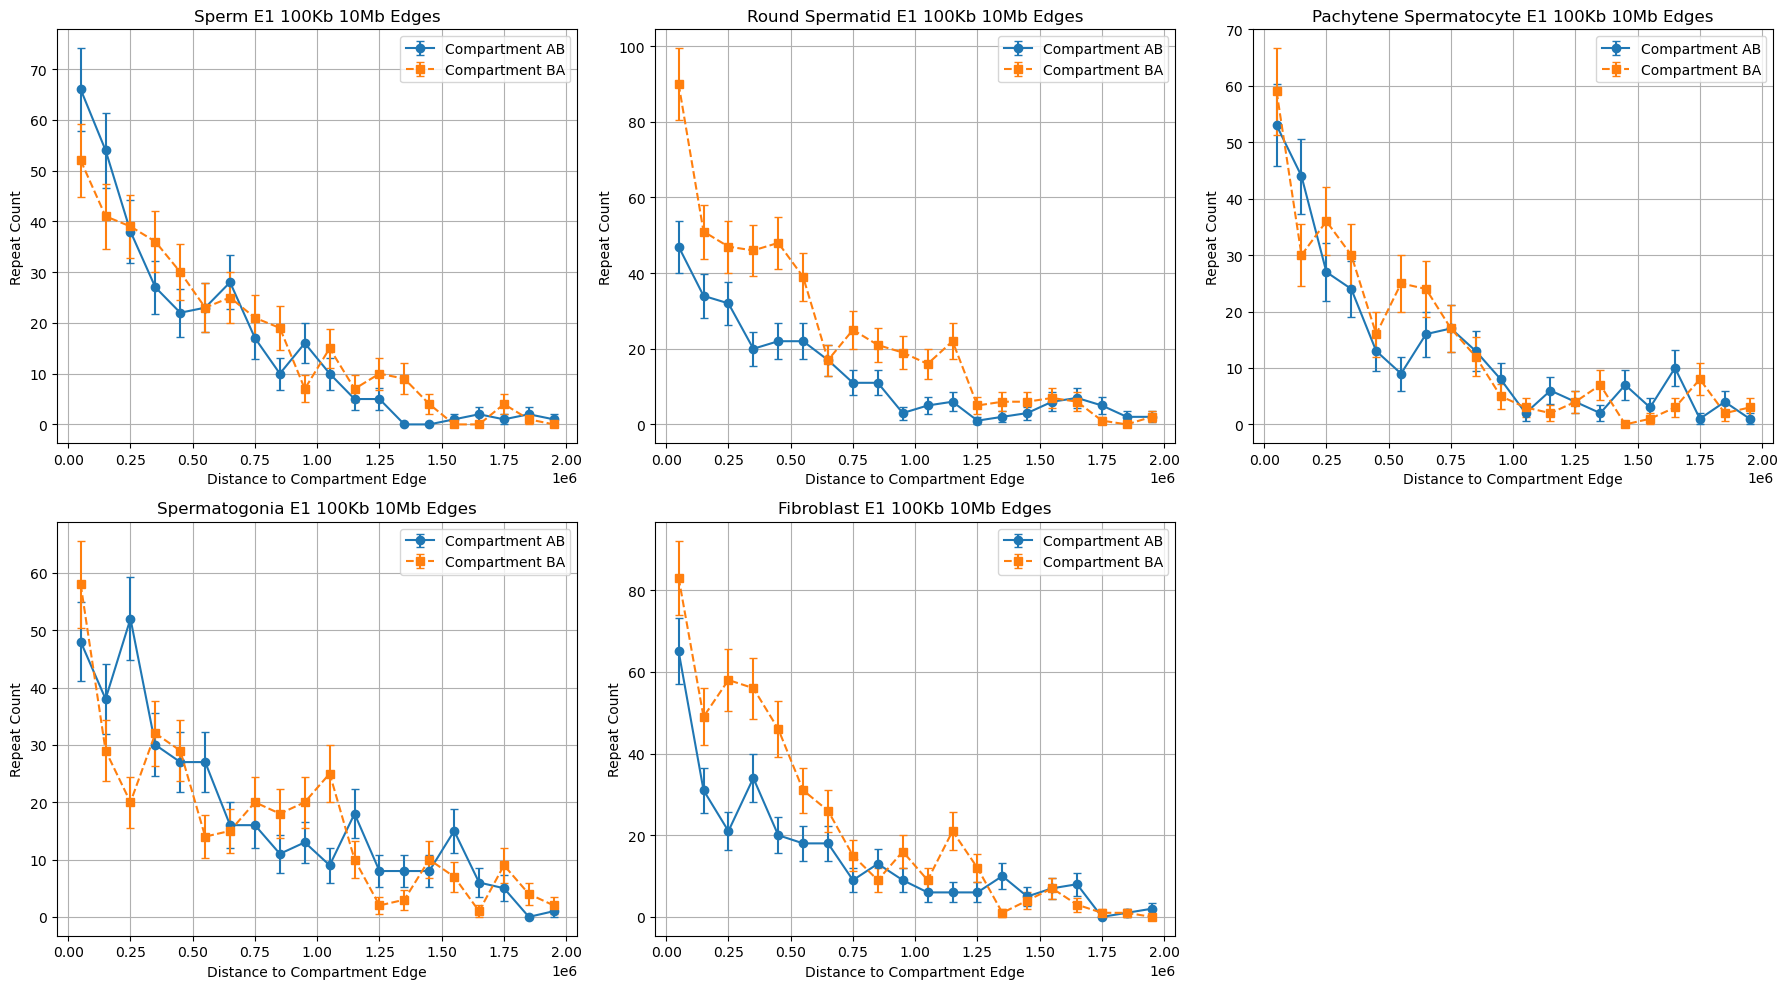

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Plot settings
num_bins = 20
max_dist = 2_000_000
bins = np.linspace(0, max_dist, num_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

def bin_absmid_with_error(absmid_values, bins):
    counts, _ = np.histogram(absmid_values, bins=bins)
    errors = np.sqrt(counts)
    return counts, errors

# Prepare plot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Loop through samples
for idx, (sample, pair) in enumerate(remapped_data.items()):
    A_df = pair["A"]
    B_df = pair["B"]

    # Bin 'absmid'
    counts_A, errors_A = bin_absmid_with_error(A_df['absmid'].dropna(), bins)
    counts_B, errors_B = bin_absmid_with_error(B_df['absmid'].dropna(), bins)

    ax = axes[idx]
    ax.errorbar(bin_centers, counts_A, yerr=errors_A, marker='o', linestyle='-', capsize=3, label='Compartment AB')
    ax.errorbar(bin_centers, counts_B, yerr=errors_B, marker='s', linestyle='--', capsize=3, label='Compartment BA')
    ax.set_title(sample.replace("_", " ").title())
    ax.set_xlabel("Distance to Compartment Edge")
    ax.set_ylabel("Repeat Count")
    ax.grid(True)
    ax.legend()

# Hide unused subplot (slot 6)
if len(remapped_data) < len(axes):
    for i in range(len(remapped_data), len(axes)):
        axes[i].axis('off')

plt.tight_layout()
plt.show()

## corected for lenght between edges

In [ ]:
import numpy as np

def bin_half_distances(comp, max_dist=2_000_000, bins=20):
    start = comp['start'].values
    # Compute half-distances between consecutive start positions
    half_distances = [(start[i+1] - start[i]) / 2 for i in range(len(start) - 1)]

    # Bin those distances
    bin_edges = np.linspace(0, max_dist, bins + 1)
    counts, _ = np.histogram(half_distances, bins=bin_edges)

    # Reverse cumulative sum — how many possible contributing edges for each bin
    reverse_cumulative_counts = np.cumsum(counts[::-1])[::-1]

    return counts, reverse_cumulative_counts

Compartment A (first 10 cumulative fractions): [0.04166667 0.10416667 0.1875     0.27083333 0.41666667 0.45833333
 0.47916667 0.54166667 0.625      0.70833333]
Compartment B (first 10 cumulative fractions): [0.0862069  0.20689655 0.29310345 0.37931034 0.48275862 0.51724138
 0.56896552 0.5862069  0.60344828 0.63793103]


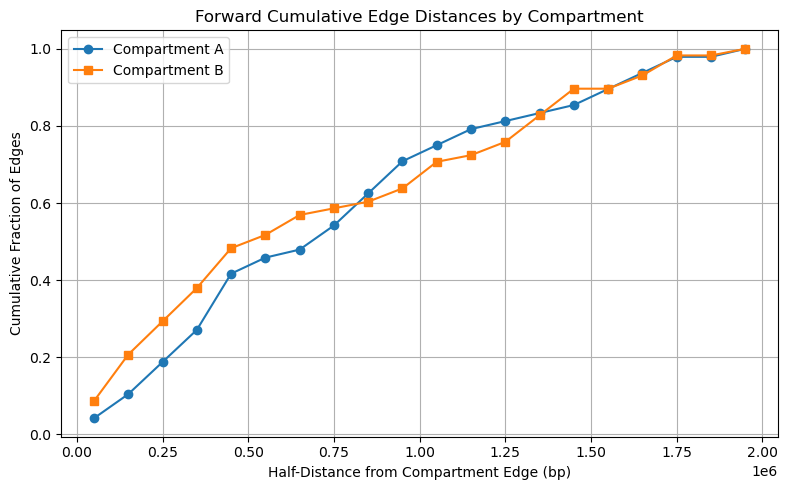

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
max_dist = 2_000_000
num_bins = 20
bin_edges = np.linspace(0, max_dist, num_bins + 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# --- Function to bin half-distances by compartment ---
def bin_half_distances_by_compartment(comp, max_dist=2_000_000, bins=20):
    bin_edges = np.linspace(0, max_dist, bins + 1)
    results = {}

    for compartment in ['A', 'B']:
        subset = comp[comp['comp'] == compartment]
        start = subset['start'].values

        if len(start) < 2:
            counts = np.zeros(bins, dtype=int)
        else:
            # Compute half-distances
            half_distances = [(start[i+1] - start[i]) / 2 for i in range(len(start) - 1)]
            counts, _ = np.histogram(half_distances, bins=bin_edges)

        results[compartment] = {
            "counts": counts,
            "cumulative_fraction": np.cumsum(counts) / np.sum(counts) if np.sum(counts) > 0 else np.zeros(bins)
        }

    return results

# --- Run the function ---
# Replace this with your actual DataFrame
# Example: edge_df = sperm_e1_100kb_10Mb_edges_AB
edge_df = sperm_e1_100kb_10Mb_edges_AB  # Example

# Get results for A and B
dist_data = bin_half_distances_by_compartment(edge_df)
print("Compartment A (first 10 cumulative fractions):", dist_data["A"]["cumulative_fraction"][:10])
print("Compartment B (first 10 cumulative fractions):", dist_data["B"]["cumulative_fraction"][:10])


# --- Plot ---
plt.figure(figsize=(8, 5))
plt.plot(bin_centers, dist_data["A"]["cumulative_fraction"], marker='o', label='Compartment A')
plt.plot(bin_centers, dist_data["B"]["cumulative_fraction"], marker='s', label='Compartment B')

plt.title("Forward Cumulative Edge Distances by Compartment")
plt.xlabel("Half-Distance from Compartment Edge (bp)")
plt.ylabel("Cumulative Fraction of Edges")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


  comp       start         end chrom
0    A   2500000.0   2500001.0  chrX
1    A   8300000.0   8300001.0  chrX
2    A   9800000.0   9800001.0  chrX
3    A  10000000.0  10000001.0  chrX
4    B  10400000.0  10400001.0  chrX
[119  92  75  60  49  39  37  28  23  19]
(20,)


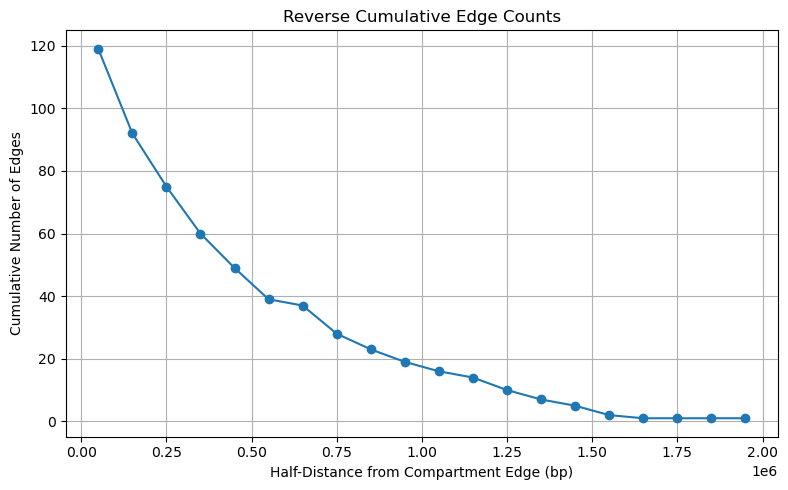

In [57]:
half_distance,reverse_cumulative  = bin_half_distances(sperm_e1_100kb_10Mb_edges_AB)
print(reverse_cumulative [:10])
print(reverse_cumulative.shape)

max_dist = 2_000_000
num_bins = 20
bin_edges = np.linspace(0, max_dist, num_bins + 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
plt.figure(figsize=(8, 5))
plt.plot(bin_centers, reverse_cumulative, marker='o')
plt.title("Reverse Cumulative Edge Counts")
plt.xlabel("Half-Distance from Compartment Edge (bp)")
plt.ylabel("Cumulative Number of Edges")
plt.grid(True)
plt.tight_layout()
plt.show()

[ 27  44  59  70  80  82  91  96 100 103]


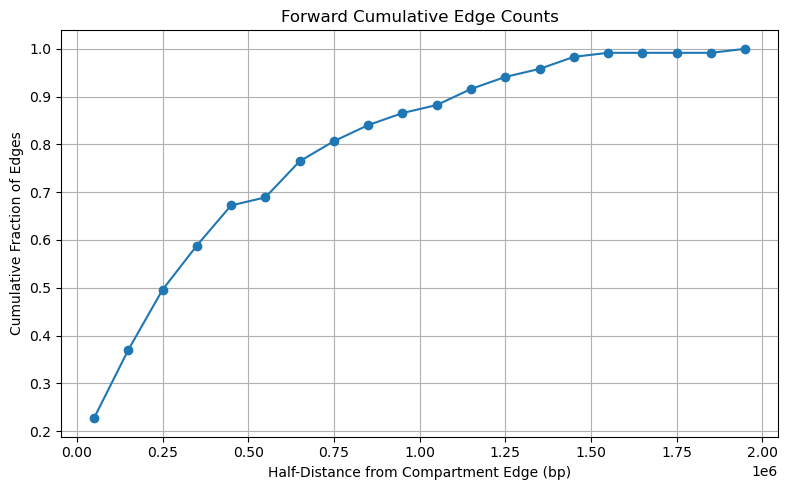

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming half_distance is the raw histogram (counts per bin)
# Convert to forward cumulative
cumulative_counts = np.cumsum(half_distance)
print(cumulative_counts[:10])  # Check first few values

# Normalize if you want values between 0 and 1
cumulative_fraction = cumulative_counts / cumulative_counts[-1]  # optional

# Plot cumulative (either raw or normalized)
plt.figure(figsize=(8, 5))
plt.plot(bin_centers, cumulative_fraction, marker='o')  # use cumulative_counts if not normalizing
plt.title("Forward Cumulative Edge Counts")
plt.xlabel("Half-Distance from Compartment Edge (bp)")
plt.ylabel("Cumulative Fraction of Edges")  # or "Cumulative Number of Edges"
plt.grid(True)
plt.tight_layout()
plt.show()


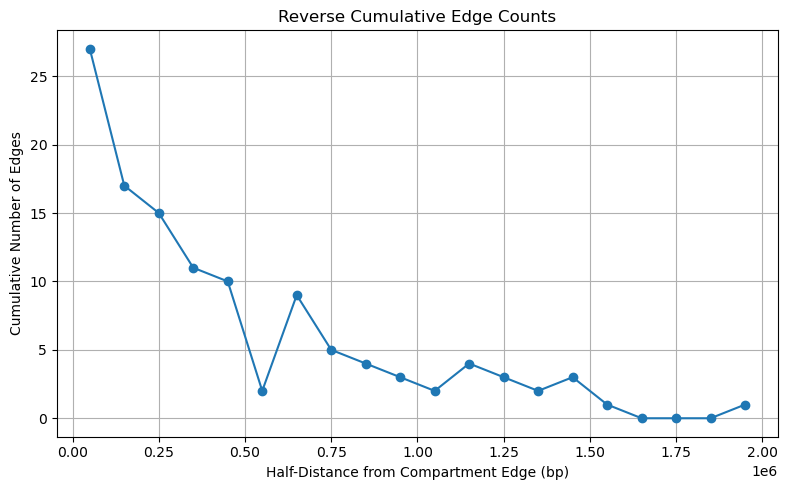

In [29]:
max_dist = 2_000_000
num_bins = 20
bin_edges = np.linspace(0, max_dist, num_bins + 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
plt.figure(figsize=(8, 5))
plt.plot(bin_centers, half_distance, marker='o')
plt.title("Reverse Cumulative Edge Counts")
plt.xlabel("Half-Distance from Compartment Edge (bp)")
plt.ylabel("Cumulative Number of Edges")
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
ab_dfs = {name: obj for name, obj in globals().items()
          if name.endswith('_AB') and isinstance(obj, pd.DataFrame)}
remapped_simple_filter_data = {}

for name, df_anchor in ab_dfs.items():
    print(f"\nRunning on: {name}")
    try:
        A_value, B_value = plot_repeat_density_vs_compartment_edge(df_chrX, df_anchor)
        remapped_simple_filter_data[name.replace('_AB', '')] = {"A": A_value, "B": B_value}
        print(f"  A_value: {A_value.shape}, B_value: {B_value.shape}")
    except Exception as e:
        print(f"  ❌ Failed on {name}: {e}")


Running on: sperm_e1_100kb_10Mb_edges_AB
  A_value: (310, 12), B_value: (384, 12)

Running on: round_spermatid_e1_100kb_10Mb_edges_AB
  A_value: (272, 12), B_value: (485, 12)

Running on: pachytene_spermatocyte_e1_100kb_10Mb_edges_AB
  A_value: (390, 12), B_value: (275, 12)

Running on: spermatogonia_e1_100kb_10Mb_edges_AB
  A_value: (393, 12), B_value: (350, 12)

Running on: fibroblast_e1_100kb_10Mb_edges_AB
  A_value: (439, 12), B_value: (335, 12)


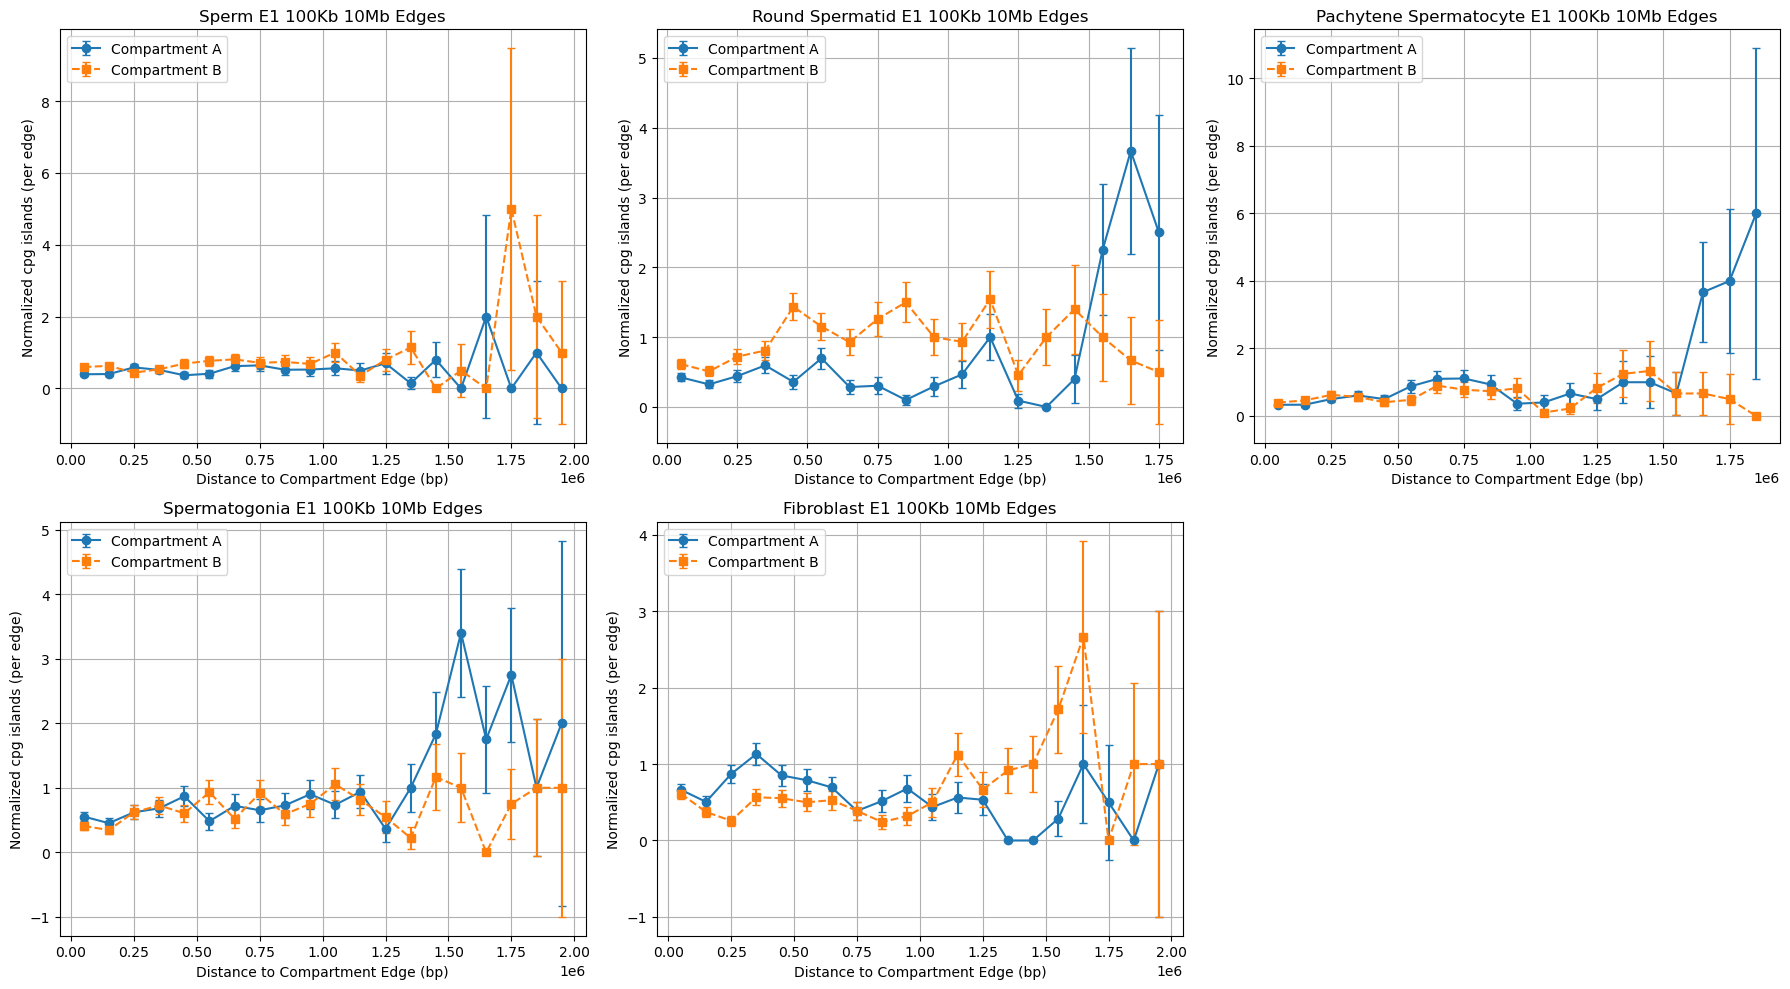

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# --- SETTINGS ---
num_bins = 20
max_dist = 2_000_000
bins = np.linspace(0, max_dist, num_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# --- UPDATED FUNCTION ---
def bin_absmid_with_error(absmid_values, bins, cumulative_fraction):
    counts, _ = np.histogram(absmid_values, bins=bins)
    errors = np.sqrt(counts)

    # Avoid division by zero or very small values
    cumulative_fraction = np.where(cumulative_fraction == 0, np.nan, cumulative_fraction)

    # Adjust errors based on normalized cumulative fraction
    adjusted_errors = errors * (1 + 1 / cumulative_fraction)
    return counts, adjusted_errors

# --- PLOT ALL SAMPLES ---
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Loop through each sample
for idx, (sample, pair) in enumerate(remapped_simple_filter_data.items()):
    A_df = pair["A"]
    B_df = pair["B"]

    # Get the edge dataframe
    edge_df = globals()[sample + "_AB"]

    # Get forward cumulative (normalized) from half distances
    edges_counts, cumulative_fraction = bin_half_distances(edge_df)

    # Compute counts and errors for A and B
    counts_A, raw_errors_A = bin_absmid_with_error(A_df['absmid'].dropna(), bins, cumulative_fraction)
    counts_B, raw_errors_B = bin_absmid_with_error(B_df['absmid'].dropna(), bins, cumulative_fraction)

    # Normalize counts
    norm_cumulative = np.where(cumulative_fraction == 0, np.nan, cumulative_fraction)
    norm_counts_A = counts_A / norm_cumulative
    norm_counts_B = counts_B / norm_cumulative
    norm_errors_A = raw_errors_A / norm_cumulative
    norm_errors_B = raw_errors_B / norm_cumulative

    # --- Plot ---
    ax = axes[idx]
    ax.errorbar(bin_centers, norm_counts_A, yerr=norm_errors_A, marker='o', linestyle='-', capsize=3, label='Compartment A')
    ax.errorbar(bin_centers, norm_counts_B, yerr=norm_errors_B, marker='s', linestyle='--', capsize=3, label='Compartment B')
    ax.set_title(sample.replace("_", " ").title())
    ax.set_xlabel("Distance to Compartment Edge (bp)")
    ax.set_ylabel("Normalized cpg islands (per edge)")
    ax.grid(True)
    ax.legend()

# Hide unused subplots
if len(remapped_simple_filter_data) < len(axes):
    for i in range(len(remapped_simple_filter_data), len(axes)):
        axes[i].axis('off')

plt.tight_layout()
plt.show()


In [31]:
ab_dfs = {name: obj for name, obj in globals().items()
          if name.endswith('_AB') and isinstance(obj, pd.DataFrame)}
remapped_data = {}

for name, df_anchor in ab_dfs.items():
    print(f"\nRunning on: {name}")
    try:
        A_value, B_value = remapping_no_filter_compartment(df_chrX, df_anchor)
        remapped_data[name.replace('_AB', '')] = {"A": A_value, "B": B_value}
        print(f"  A_value: {A_value.shape}, B_value: {B_value.shape}")
    except Exception as e:
        print(f"  ❌ Failed on {name}: {e}")


Running on: sperm_e1_100kb_10Mb_edges_AB
  A_value: (342, 12), B_value: (352, 12)

Running on: round_spermatid_e1_100kb_10Mb_edges_AB
  A_value: (273, 12), B_value: (484, 12)

Running on: pachytene_spermatocyte_e1_100kb_10Mb_edges_AB
  A_value: (310, 12), B_value: (355, 12)

Running on: spermatogonia_e1_100kb_10Mb_edges_AB
  A_value: (380, 12), B_value: (363, 12)

Running on: fibroblast_e1_100kb_10Mb_edges_AB
  A_value: (305, 12), B_value: (469, 12)


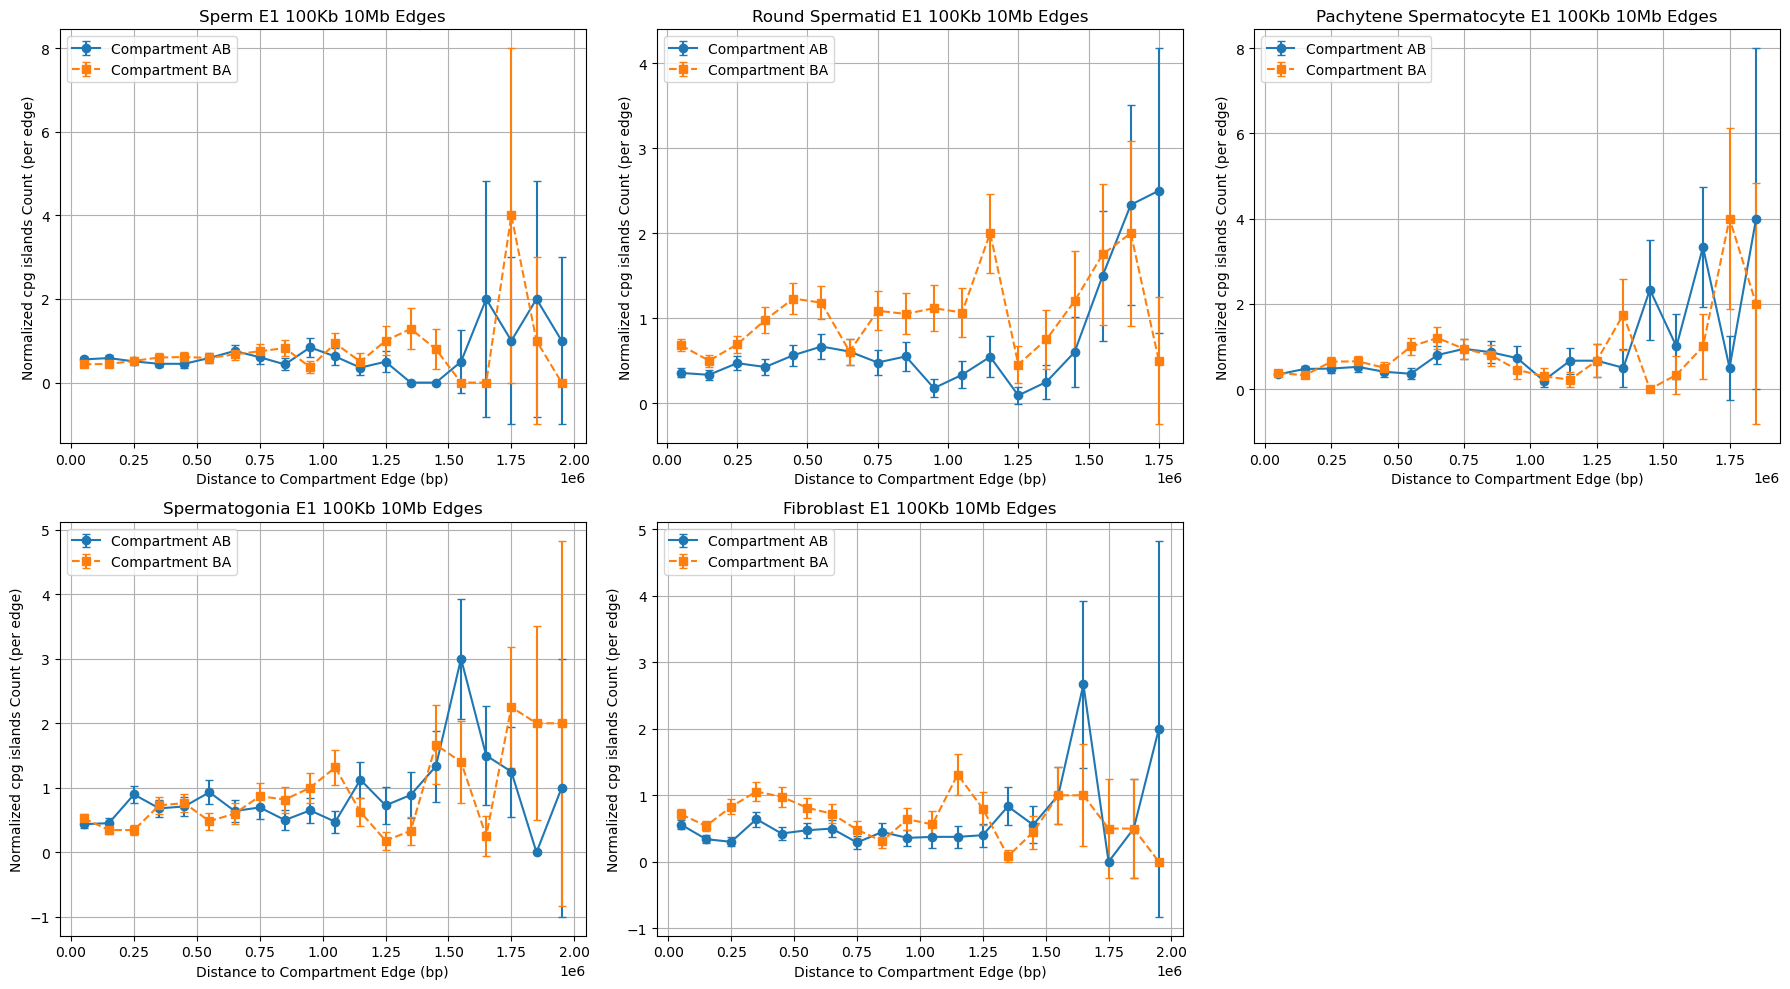

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Plot settings
num_bins = 20
max_dist = 2_000_000
bins = np.linspace(0, max_dist, num_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Updated error calculation function
def bin_absmid_with_error(absmid_values, bins, cumulative_fraction):
    counts, _ = np.histogram(absmid_values, bins=bins)
    errors = np.sqrt(counts)

    # Prevent division by 0
    cumulative_fraction = np.where(cumulative_fraction == 0, np.nan, cumulative_fraction)

    # Scale errors by inverse contribution per bin
    adjusted_errors = errors * (1 + 1 / cumulative_fraction)
    return counts, adjusted_errors

# Create plot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Loop over each sample in remapped_data
for idx, (sample, pair) in enumerate(remapped_data.items()):
    A_df = pair["A"]
    B_df = pair["B"]

    # Retrieve edge DataFrame for the sample
    edge_df = globals()[sample + "_AB"]

    # Calculate forward cumulative (normalized)
    edges_counts, cumulative_fraction = bin_half_distances(edge_df)

    # Bin counts and errors using the cumulative_fraction
    counts_A, raw_errors_A = bin_absmid_with_error(A_df['absmid'].dropna(), bins, cumulative_fraction)
    counts_B, raw_errors_B = bin_absmid_with_error(B_df['absmid'].dropna(), bins, cumulative_fraction)

    # Normalize counts
    norm_cumulative = np.where(cumulative_fraction == 0, np.nan, cumulative_fraction)
    norm_counts_A = counts_A / norm_cumulative
    norm_counts_B = counts_B / norm_cumulative
    norm_errors_A = raw_errors_A / norm_cumulative
    norm_errors_B = raw_errors_B / norm_cumulative

    # Plot A vs B in current subplot
    ax = axes[idx]
    ax.errorbar(bin_centers, norm_counts_A, yerr=norm_errors_A, marker='o', linestyle='-', capsize=3, label='Compartment AB')
    ax.errorbar(bin_centers, norm_counts_B, yerr=norm_errors_B, marker='s', linestyle='--', capsize=3, label='Compartment BA')
    ax.set_title(sample.replace("_", " ").title())
    ax.set_xlabel("Distance to Compartment Edge (bp)")
    ax.set_ylabel("Normalized cpg islands Count (per edge)")
    ax.grid(True)
    ax.legend()

# Hide unused subplot(s)
if len(remapped_data) < len(axes):
    for i in range(len(remapped_data), len(axes)):
        axes[i].axis('off')

plt.tight_layout()
plt.show()


## notes for cpg islands

CpG islands, which are typically unmethylated and associated with gene promoters, play a pivotal role in chromatin accessibility and 3D genome organization. Multiple studies have demonstrated that chromatin compartment transitions (A to B or vice versa) can be driven or accompanied by changes in CpG island methylation, histone modifications, or chromatin-binding proteins. These changes are often observed in development, cancer progression, X-chromosome inactivation, and transcriptional regulation. CGIs frequently serve as anchors or boundaries for chromatin domains and their epigenetic status can correlate with large-scale compartment reorganization, particularly between transcriptionally active A compartments and repressive B compartments.

### artikler
Reprogramming of Meiotic Chromatin Architecture during Spermatogenesis (6)
Key Findings Summary
This paper investigates how 3D chromatin architecture is reorganized during spermatogenesis—specifically in rhesus monkey and mouse models—using low-input Hi-C (a chromosome conformation capture method).

Major Contributions:
Loss and Re-establishment of TADs (Topologically Associating Domains):

During meiosis, particularly in pachytene spermatocytes, most canonical TADs dissolve even though transcription continues. This suggests that TAD structure is not strictly required for active gene expression at this stage.

Emergence of Refined Local A/B Compartments:

- Instead of standard large-scale A/B compartmentalization, fine-grained compartmental structures emerge. These “refined-A/B compartments” alternate between transcriptionally active and inactive domains.

- hese compartments are smaller, and their emergence implies a compartmental organization decoupled from transcription activity.- 

Synaptonemal Complex Dependency:

- These refined compartments require a functional synaptonemal complex (SC). In SC-defective mutants, canonical TADs are restored, suggesting that the SC actively suppresses TADs while enabling fine-scale compartmentalization.

- This is a novel role for the SC in 3D genome reorganization, beyond its known mechanical role in chromosome pairing and crossover formation.

Conservation Across Species:

- The unique meiotic chromatin organization found in rhesus monkeys is conserved in mice, suggesting this is a mammalian-wide regulatory principle during gametogenesis.


##### Implication for CpG Islands:
While CpG islands (CGIs) are not the primary focus of this paper, the study supports the broader hypothesis that CGIs may serve as boundary or anchoring elements in fine-scale compartment formation during meiosis:

The refined-A/B structure shows domain transitions that correlate with transcription activity, a feature often influenced by CGI presence at promoter regions.

Since CGIs are associated with active transcription start sites, they likely anchor boundaries between alternating compartments, effectively contributing to local chromatin insulation or regulation.

@article{Wang2019,
  year = {2019},
  title = {{Reprogramming of Meiotic Chromatin Architecture during Spermatogenesis}},
  author = {Wang, Yu and Wang, Hui and Zhang, Yixiao and Du, Zheng and Si, Wei and Fan, Shuhan and Qin, Dong and Liu, Yuliang and Liu, Yuhan and Xu, Shiyuan and others},
  journal = {Molecular Cell},
  issn = {1097-4164},
  doi = {10.1016/j.molcel.2018.11.019},
  abstract = {{Chromatin organization undergoes drastic reconfiguration during gametogenesis. However, the molecular reprogramming of three-dimensional chromatin structure in this process remains poorly understood for mammals, including primates. Here, we examined three-dimensional chromatin architecture during spermatogenesis in rhesus monkey using low-input Hi-C. Interestingly, we found that topologically associating domains (TADs) undergo dissolution and reestablishment in spermatogenesis. Strikingly, pachytene spermatocytes, where synapsis occurs, are strongly depleted for TADs despite their active transcription state but uniquely show highly refined local compartments that alternate between transcribing and non-transcribing regions (refined-A/B). Importantly, such chromatin organization is conserved in mouse, where it remains largely intact upon transcription inhibition. Instead, it is attenuated in mutant spermatocytes, where the synaptonemal complex failed to be established. Intriguingly, this is accompanied by the restoration of TADs, suggesting that the synaptonemal complex may restrict TADs and promote local compartments. Thus, these data revealed extensive reprogramming of higher-order meiotic chromatin architecture during mammalian gametogenesis.}},
  volume = {73},
  number = {3},
  pages = {547--561.e6},
  pmid = {30686580},
  local-url = {https://www.cell.com/molecular-cell/fulltext/S1097-2765(18)30989-4}
}



##### maybe  relevant articles:

Reconstructing A/B compartments as revealed by Hi-C using long-range correlations in epigenetic data (3)

Smchd1-Dependent and -Independent Pathways Determine Developmental Dynamics of CpG Island Methylation on the Inactive X Chromosome (4)